In [2]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [5]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

<h2>Neural Network</h2>

In [18]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
#         print("hello")
#         print(m)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [19]:
temp = ActorCritic(envs.observation_space.shape[0],envs.action_space.shape[0],10).to(device)
print(temp)
temp_state = envs.reset()
temp_state = torch.FloatTensor(temp_state).to(device)
tm_dist, tm_val = temp(temp_state)
print(temp_state)
print(tm_dist.sample())
print(tm_dist)
print(tm_val)

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
tensor([[ 0.9536, -0.3012, -0.9155],
        [ 0.0483,  0.9988,  0.3993],
        [ 0.4146, -0.9100, -0.6050],
        [-0.4179, -0.9085,  0.8150],
        [-0.3031, -0.9530,  0.7499],
        [ 0.0602,  0.9982, -0.6320],
        [-0.9819,  0.1893, -0.9013],
        [ 0.9277,  0.3734,  0.5529],
        [ 0.9466,  0.3223, -0.0761],
        [-0.8658, -0.5003, -0.7582],
        [-0.9185,  0.3953,  0.9627],
        [-0.7720, -0.6357, -0.7106],
        [ 0.6958, -0.7183,  0.5680],
        [-0.7593,  0.6508, -0.4263],
        [ 0.9118, -0.4106,  0.6329],
        [-0.9122, -0.4097, -0.9279]])
tensor([[ 0.7515],
        [ 0.6436],
        [-0.3729],
        [-0.

In [19]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

<h2>GAE</h2>

In [20]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [35]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage 
        in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
class CustomActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var, safety_dim):
        super(ActorCritic, self).__init__()


        layers_shared_actor = []
        layers_safety_actor = []
        layers_control_actor = []

        layers_shared_critic = []
        layers_safety_critic = []
        layers_control_critic = []
        

        in_dim = state_dim
        out_dim = n_latent_var

        # shared part
        for i in range(Num_Hidden_Shared):
            layers_shared_actor.append(nn.Linear(in_dim, out_dim))
            layers_shared_actor.append(nn.Tanh())
            in_dim = out_dim

        # safety head
        for i in range(Num_Hidden_Safety):
            layers_safety_actor.append(nn.Linear(in_dim, out_dim))
            layers_safety_actor.append(nn.Tanh())

        # action head
        for i in range(Num_Hidden_Action):
            layers_control_actor.append(nn.Linear(in_dim, out_dim))
            layers_control_actor.append(nn.Tanh())

        self.base_actor = nn.Sequential(*layers_shared_actor)

        self.safety_layer_actor = nn.Sequential(*layers_safety_actor,
                                    nn.Linear(out_dim, safety_dim)
                                    )
        
        self.control_layer_actor = nn.Sequential(*layers_control_actor,
                                    nn.Linear(out_dim, action_dim)
                                    )


        in_dim = state_dim
        out_dim = n_latent_var

        # shared part
        for i in range(Num_Hidden_Shared):
            layers_shared_critic.append(nn.Linear(in_dim, out_dim))
            layers_shared_critic.append(nn.Tanh())
            in_dim = out_dim

        # safety head
        for i in range(Num_Hidden_Safety):
            layers_safety_critic.append(nn.Linear(in_dim, out_dim))
            layers_safety_critic.append(nn.Tanh())

        # action head
        for i in range(Num_Hidden_Action):
            layers_control_critic.append(nn.Linear(in_dim, out_dim))
            layers_control_critic.append(nn.Tanh())

        self.base_critic = nn.Sequential(*layers_shared_critic)

        self.safety_layer_critic = nn.Sequential(*layers_safety_critic,
                                    nn.Linear(out_dim, 1)
                                    )
        
        self.action_layer_critic = nn.Sequential(*layers_control_critic,
                                    nn.Linear(out_dim, 1)
                                    )

        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        mu1 = self.control_layer_actor(self.base_actor(state)) # mu1
        mu2 = self.safety_layer_actor(self.base_actor(state)) # mu2
        
        std1   = self.log_std.exp().expand_as(mu1)
        dist1  = Normal(mu1, std1)

        std2   = self.log_std.exp().expand_as(mu2)
        dist2  = Normal(mu1, std2)

        return dist1, dist2
        
        # memory.states.append(state)
        # memory.actions.append(action)
        
#         return action.item(), safety.item()
    
    def evaluate(self, state, action):
        # action_probs = self.action_layer(state)
        # dist = Categorical(action_probs)
        
        # action_logprobs = dist.log_prob(action)
        # dist_entropy = dist.entropy()
        
        control_state_value = self.control_layer_critic(self.base_critic(state))
        safety_state_value = self.safety_layer_critic(self.base_critic(state))

        # return action_logprobs, torch.squeeze(state_value), dist_entropy
        return control_state_value, safety_state_value


In [ ]:
'''
We need to update the weights of safety side similar to control side. (by symmetry)
We just need to get the same inputs that are required to calculate the losses from the safety part as well

Just assume we have two networks and we want to do ppo on both of them. So calculate loss and do weighted addition
and back propagate

Equivalents needed:
    actions : safety
    log_probs : safety_log_probs
    returns : safety_returns
    advantages : safety_advantages
    



'''
CTRL_W = 0.7
SFTY_W = 0.3


# def ppo_iter_new(mini_batch_size, states, actions, log_probs, returns, advantage):
def ppo_iter_new(mini_batch_size, states, controls, safetys, log_probs_c, log_probs_s, returns_c, returns_s, \
                 advantages_c, advantages_s):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
#         yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        yield states[rand_ids, :], controls[rand_ids, :], safetys[rand_ids, :], log_probs_c[rand_ids, :], \
    log_probs_s[rand_ids, :], returns_c[rand_ids, :], returns_s[rand_ids, :], advantages_c[rand_ids, :], advantages_s[rand_ids, :]
        
        

# def ppo_update_new(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
def ppo_update_new(ppo_epochs, mini_batch_size, states, controls, safetys, log_probs_c, log_probs_s \
                   , returns_c, returns_s, advantages_c, advantages_s, clip_param=0.2):
    for _ in range(ppo_epochs):
        
#         for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
        for state, control, safety, old_log_probs_c, old_log_probs_s, return_c, return_s, advantage_c, advantage_s \
                        in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):

#             dist, value = model(state)
            dist_c, dist_s = model.act(state)
            value_c, value_s  = model.evaluate(state)

#             entropy = dist.entropy().mean()
            entropy_c = dist_c.entropy().mean()
            entropy_s = dist_s.entropy().mean()
        
#             new_log_probs = dist.log_prob(action)                
            new_log_probs_c = dist_c.log_prob(control)
            new_log_probs_s = dist_s.log_prob(safety)
        
        
#             ratio = (new_log_probs - old_log_probs).exp()
            ratio_c = (new_log_probs_c - old_log_probs_c).exp()
            ratio_s = (new_log_probs_s - old_log_probs_s).exp()
    
#             surr1 = ratio * advantage
            surr1_c = ratio_c * advantage_c
            surr1_s = ratio_s * advantage_s
    
#             surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage
            surr2_c = torch.clamp(ratio_c, 1.0 - clip_param, 1.0 + clip_param) * advantage_c
            surr2_s = torch.clamp(ratio_s, 1.0 - clip_param, 1.0 + clip_param) * advantage_s
    
    
#             actor_loss  = - torch.min(surr1, surr2).mean()
            actor_loss_c = - torch.min(surr1_c, surr2_c).mean()
            actor_loss_s = - torch.min(surr1_s, surr2_s).mean()
    
#             critic_loss = (return_ - value).pow(2).mean()
            critic_loss_c = (return_c - value_c).pow(2).mean()
            critic_loss_s = (return_s - value_s).pow(2).mean()


#             loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
            loss_c = 0.5 * critic_loss_c + actor_loss_c - 0.001 * entropy_c
            loss_s = 0.5 * critic_loss_s + actor_loss_s - 0.001 * entropy_s
    
            loss = CTRL_W*loss_c + SFTY_W*loss_s

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [22]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [23]:
max_frames = 15000
frame_idx  = 0
test_rewards = []

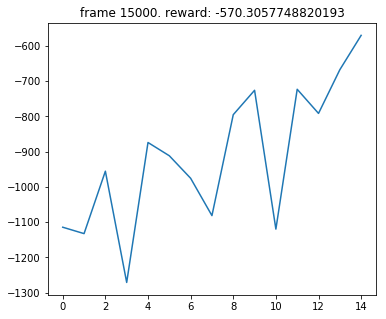

In [24]:
state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

<h1>Saving trajectories for GAIL</h1>

In [15]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)

episode: 0 reward: -9.379095587032706
episode: 1 reward: -9.650909347140873
episode: 2 reward: -9.239020824482216
episode: 3 reward: -9.08145820218229
episode: 4 reward: -9.754058352832722
episode: 5 reward: -8.787385990259725
episode: 6 reward: -9.960827471049809
episode: 7 reward: -9.383103664844352
episode: 8 reward: -9.21930627510877
episode: 9 reward: -9.392032602524893
episode: 10 reward: -8.971582591460887
episode: 11 reward: -9.117912064597304
episode: 12 reward: -8.78152662300433
episode: 13 reward: -9.890438673703049
episode: 14 reward: -9.54285322963302
episode: 15 reward: -9.41677616518869
episode: 16 reward: -8.978002589039926
episode: 17 reward: -9.786747572291842
episode: 18 reward: -9.040926985899137
episode: 19 reward: -9.48965082152691
episode: 20 reward: -9.508202258492254
episode: 21 reward: -9.057053059323461
episode: 22 reward: -9.819452759432647
episode: 23 reward: -9.805622747689124
episode: 24 reward: -9.254766119386941
episode: 25 reward: -9.474071662816893
ep